# Queries and Analysis
The scope of this  notebook is limited to the development of a query and an analysis of the weather data.
## Queries:
- Last 12 months of date and prcp
-- Plot x: date, y: prcp type: bar
- Station Count
- Rank of Stations by observation count
- Station with Max observation count
- Last 12 months of temp data from station with max observation count.
-- Plot x: temp, y: temp count type: histogram
## Bonus: Queries
- Daily temps in June, Daily temps in December:
- Average temps over a time window on past years :  Plot y: avg temp, err_bar: tmax-tmin
- Daily Rain Fall Averages
- Daily Norms - Plot: y: temp (min, avg, max), x:date type: area

In [1]:
# We will use alot of the same libraries from the data clenaing. Perhaps
from sqlalchemy import create_engine, desc, MetaData, Table
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import func
# For calculationg a year back from the newest record:
import datetime as dt
from datetime import datetime
# Just in case we have to deal with leap years:
from dateutil.relativedelta import relativedelta
# Pandas and Seaborn for visualizations:
import pandas as pd
import seaborn as sns

In [2]:
# initiate base object:
Base = automap_base()
# Database connection setup:
database_path = r"C:\Users\Juan\bootcamp\Homework\homework_08\data\hawaii.sqlite"
engine = create_engine(f'sqlite:///{database_path}',  connect_args={'timeout': 15})
metadata = MetaData()
metadata.reflect(bind=engine)
# Reflect the database into the orm classes:
Base = automap_base(metadata=metadata)
Base.prepare()
#Table references
Measurement = Base.classes.measurement
Station = Base.classes.station
Imputed = Base.classes.imputed
# Final_Measurement = Base.classes.final_measurement
# A Session to to the queries with:
Session = sessionmaker(bind=engine)
session = Session()
Base.classes.keys()
Final_Measurement = Table("final_measurement", metadata, autoload=True, autoload_with=engine)


In [3]:
# Precipitation from the last year:
def last_date(column,date_format):
    ''' Return a datetime object representing the most recent date in the database
    Arguments:
        * table: The table your date column is in 
        * column: Column with dates 
        * date_format: string like %Y-%M-%d

    Returns: 
        * : .
    '''
    return datetime.strptime(session.query(func.max(column)).first()[0], date_format).date()
    # return datetime.strptime(session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0], date_format).date()
def one_year_ago(column, date_format):
    ''' Returns The date exactly a year prior  to the newest record in a table
    Arguments:
        * table: The table your date column is in 
        * column: Column with dates 
        * date_format: string like %Y-%M-%d
        
    Returns: 
        * year_ago_date:
    '''
    ref_date = last_date(column, date_format)
    #print(f'newest record date: {ref_date}')
    ref_date = ref_date - relativedelta(years=1)
    #print(f'year before newest record: {ref_date}')
    return ref_date 

def query_prcp_year(date, table, date_format):
    columns = ['id', 'date', 'prcp']
    prcp_year = session.query(table.id, table.date, table.prcp)\
                .filter(table.date.between\
                (one_year_ago(table.date, date_format),date))\
                .order_by(table.id)
    prcp_year = pd.DataFrame\
                .from_records(prcp_year.all(),columns=columns)
    return  prcp_year


In [4]:
# prcp analysis
date_format = r'%Y-%m-%d'
columns = ['id', 'date', 'prcp']
newest_record = last_date(Measurement.date, date_format)
one_year_ago(Measurement.date, date_format)
df = query_prcp_year(newest_record, Measurement, date_format)
df[['prcp']].describe()

# df = pd.DataFrame.from_records(filtered_query, columns=columns)

,prcp
count,2230.000000
mean,0.172354
std,0.439501
min,0.000000
25%,0.000000
50%,0.030000
75%,0.140000
max,6.700000


In [5]:
df[['date', 'prcp']].to_json(orient='records', indent=4)

'[\n    {\n        "date":"2016-08-23",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-08-24",\n        "prcp":0.08\n    },\n    {\n        "date":"2016-08-25",\n        "prcp":0.08\n    },\n    {\n        "date":"2016-08-26",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-08-27",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-08-28",\n        "prcp":0.01\n    },\n    {\n        "date":"2016-08-29",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-08-30",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-08-31",\n        "prcp":0.13\n    },\n    {\n        "date":"2016-09-01",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-09-02",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-09-03",\n        "prcp":0.0\n    },\n    {\n        "date":"2016-09-04",\n        "prcp":0.03\n    },\n    {\n        "date":"2016-09-05",\n        "prcp":0.09\n    },\n    {\n        "date":"2016-09-06",\n        "prcp":0.12\n    },\n    {\n       

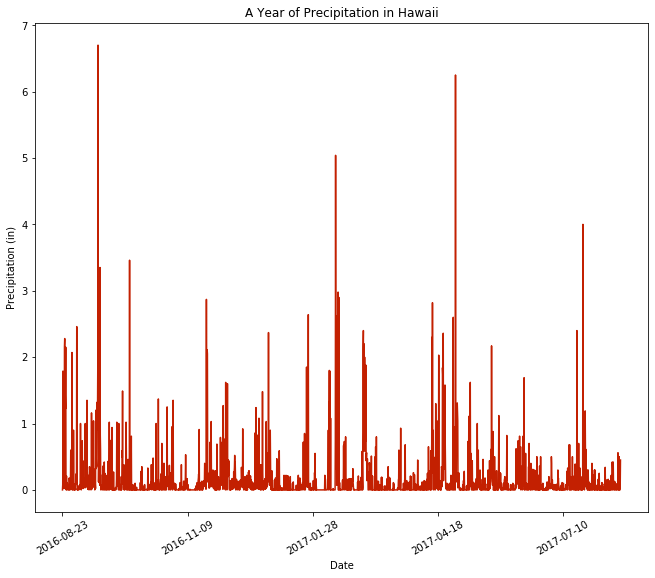

In [6]:
# Previous Year Precip Plot
from matplotlib import pyplot as plt
import calendar
df.set_index(df['date'], inplace=True)
# Chose the color of the Hibiscus Kokio Kokee one of the Hawaiin state flowers.
df['prcp'].sort_index().plot(figsize=(11,9), title='A Year of Precipitation in Hawaii', color='#C32001')
plt.ylabel('Precipitation (in)')
plt.xlabel('Date', rotation=0)
plt.xticks(rotation=30)
df[['prcp']].tail()
plt.savefig('a_years_precip.svg', format='svg')

In [7]:
# Station Analysis
#This line finds gives us the station with the most observations to feed into the tohs query below
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station))[-1][0]
station_count = len(session.query(Station.name).all())
def query_tobs_year(date, table, date_format, station):
    columns = ['id', 'date', 'tobs']
    tobs_year = session.query(table.id, table.date, table.tobs)\
                .filter(table.date.between\
                (one_year_ago(table.date, date_format),date))\
                .filter(table.station==station)
    tobs_year = pd.DataFrame\
                .from_records(tobs_year.all(),columns=columns)
    return  tobs_year  
print(f'Most Active Staion: {most_active_station} \nStation count: {station_count}')

Most Active Staion: USC00519281 
Station count: 9


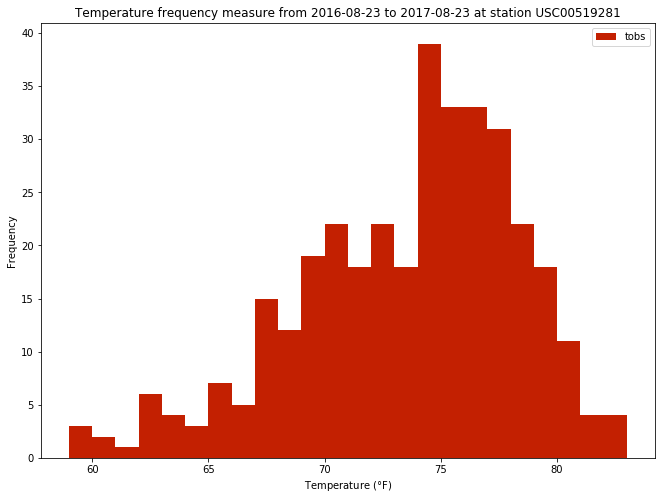

In [8]:
from matplotlib import pyplot as plt
df = query_tobs_year(newest_record, Measurement, date_format, most_active_station)
df[['date','tobs']].plot.hist(bins=24, color='#C32001', title=f'Temperature frequency measure from {one_year_ago(Measurement.date, date_format)} to {newest_record} at station {most_active_station}',figsize=(11,8))

plt.xlabel(r'Temperature ($\degree$F)')
plt.savefig('tmp_freq.svg', format='svg')

In [9]:
# stat summary: takes (start,end) tuples, a table, date format, and  and counts